# Residual Networks
[Residual Block](https://paperswithcode.com/method/residual-block)

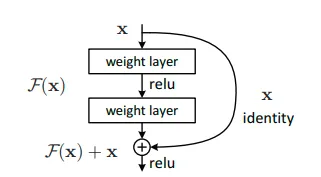

**Import libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)

# Basic Building Blocks
**Components:**
- Two convolutional layers
- Batch normalization after each conv layer
- ReLU activation
- No skip connection

In [ ]:
# Define a basic block without skip connection
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

# Residual block
**Advantages** of Residual Connections
   - Direct path for gradient backpropagation
   - Reduces vanishing gradient problem
   - Enables training of deeper networks

**Components:**
- Identity shortcut connection
- Downsample layer for channel matching
- Element-wise addition of identity and transformed features

In [ ]:
# Define a residual block with skip connection
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity  # Skip connection
        out = self.relu(out)
        return out

# Define networks
**Architectural Details:**
1. **Initial Layer:**
   - 3→64 channels
   - 3x3 convolution
   - Batch normalization
   - ReLU activation

2. **Feature Extraction Layers:**
   - Layer 1: 64 channels (5 blocks)
   - Layer 2: 128 channels (5 blocks)
   - Layer 3: 256 channels (5 blocks)
   - Layer 4: 512 channels (5 blocks)

3. **Classification Head:**
   - Global average pooling
   - Fully connected layer to classes

In [ ]:
# Define networks
class Network(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(Network, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0])

        self.layer2 = self._make_layer(block, 128, num_blocks[1])
        self.layer3 = self._make_layer(block, 256, num_blocks[2])
        self.layer4 = self._make_layer(block, 512, num_blocks[3])
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.in_channels, out_channels))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Training function

In [ ]:
# Training function
def train(model, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.3f}')

    return train_losses

# load data

In [ ]:
# Prepare CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Use only 1/10 of the data
# 0,1,2,...,59999
# 500,1,689,..
train_indices = torch.randperm(len(trainset))[:len(trainset) // 10]
trainset = torch.utils.data.Subset(trainset, train_indices)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)


100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


**Create model, training process and plotting graph.**

Training Plain Network:
Epoch 1, Loss: 2.295
Epoch 2, Loss: 2.148
Epoch 3, Loss: 2.033
Epoch 4, Loss: 2.005
Epoch 5, Loss: 1.948
Epoch 6, Loss: 1.933
Epoch 7, Loss: 1.904
Epoch 8, Loss: 1.860
Epoch 9, Loss: 1.827
Epoch 10, Loss: 1.823

Training Residual Network:
Epoch 1, Loss: 2.207
Epoch 2, Loss: 1.849
Epoch 3, Loss: 1.762
Epoch 4, Loss: 1.719
Epoch 5, Loss: 1.674
Epoch 6, Loss: 1.591
Epoch 7, Loss: 1.524
Epoch 8, Loss: 1.515
Epoch 9, Loss: 1.516
Epoch 10, Loss: 1.426


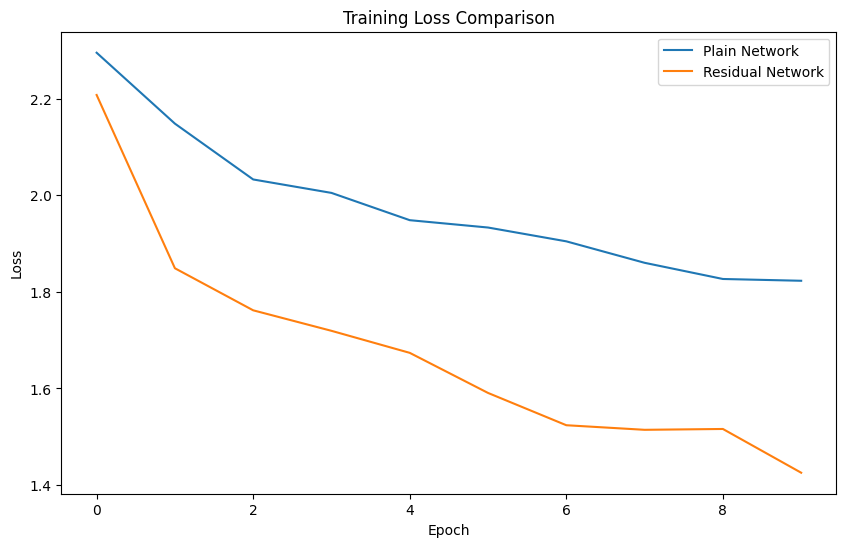

In [ ]:
# Create models
plain_network = Network(BasicBlock, [5, 5, 5, 5])
residual_network = Network(ResidualBlock, [5, 5, 5, 5])


# Train both networks
print("Training Plain Network:")
plain_losses = train(plain_network)

print("\nTraining Residual Network:")
residual_losses = train(residual_network)

# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(plain_losses, label='Plain Network')
plt.plot(residual_losses, label='Residual Network')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()


In [ ]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

**Create pdf file for saving our model architecture**

In [ ]:
# prompt: visualize the residual_network model architecture

from torchviz import make_dot
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Visualize the model architecture
x = torch.randn(1, 3, 32, 32)  # Example input
y = residual_network(x.to(device))
g = make_dot(y, params=dict(residual_network.named_parameters()))
g.render('residual_network_architecture', view=True)


'residual_network_architecture.pdf'

In [ ]:
x = torch.randn(1, 3, 32, 32)  # Example input
y = plain_network(x.to(device))
g = make_dot(y, params=dict(plain_network.named_parameters()))
g.render('plain_network_architecture', view=True)

'plain_network_architecture.pdf'

In [ ]:
print(residual_network)